In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [9]:
#%% Data Loading and Preprocessing

np.random.seed(0)

# Load your data
data = pd.read_csv('state_action.csv', index_col=None)

# Select a subset of the data
data_size = 200000
selected_idx = np.random.randint(0, len(data) - 1, size=data_size)
data_select = data.iloc[selected_idx][['start_type', 'act_num', 'mode_num', 'end_type']]

# One-hot encode the selected data
encoder = OneHotEncoder(sparse_output=False)
one_hot_data = encoder.fit_transform(data_select.values)

# Convert the data to torch tensors
data_tensor = torch.tensor(one_hot_data, dtype=torch.float32)
dataset = TensorDataset(data_tensor)

# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create DataLoader with batch size 256
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)



Using device: cuda:1


In [10]:
#%% 2. Defining the Normalizing Flow Model

class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(RealNVP, self).__init__()
        # Register mask as a buffer to ensure it moves with the model
        self.register_buffer('mask', mask.float())
        self.s = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )
        self.t = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        x_masked = x * self.mask
        s = self.s(x_masked) * (1 - self.mask)
        t = self.t(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = ((1 - self.mask) * s).sum(dim=1)
        return y, log_det_jacobian
    
    def inverse(self, y):
        y_masked = y * self.mask
        s = self.s(y_masked) * (1 - self.mask)
        t = self.t(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * (y - t) * torch.exp(-s)
        log_det_jacobian = -((1 - self.mask) * s).sum(dim=1)
        return x, log_det_jacobian

class NormalizingFlowModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_flows, device):
        super(NormalizingFlowModel, self).__init__()
        self.device = device
        self.prior = torch.distributions.MultivariateNormal(
            torch.zeros(input_dim).to(device), torch.eye(input_dim).to(device)
        )
        self.flows = nn.ModuleList()
        # Create alternating binary masks
        mask = (torch.arange(0, input_dim) % 2).to(device).float()
        for _ in range(n_flows):
            self.flows.append(RealNVP(input_dim, hidden_dim, mask))
            mask = 1 - mask  # Alternate mask
    
    def forward(self, x):
        log_det_jacobian = torch.zeros(x.size(0), device=self.device)
        for flow in self.flows:
            x, ldj = flow(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian
    
    def inverse(self, z):
        for flow in reversed(self.flows):
            z, _ = flow.inverse(z)
        return z


In [11]:
#%% 3. Training the Normalizing Flow Model

# Hyperparameters
input_dim = data_tensor.shape[1]
hidden_dim = 256
n_flows = 10  # Adjust as needed
batch_size = 256
num_epochs = 30  # Increase epochs for better results
learning_rate = 5e-5  # Adjust learning rate if needed

# Initialize model and optimizer
model = NormalizingFlowModel(input_dim, hidden_dim, n_flows, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        z, log_det_jacobian = model(x)
        log_prob_z = model.prior.log_prob(z)
        loss = - (log_prob_z + log_det_jacobian).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(data_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/30, Loss: 28.2642
Epoch 2/30, Loss: 2.5720
Epoch 3/30, Loss: -16.2837
Epoch 4/30, Loss: -28.9146
Epoch 5/30, Loss: -37.4437
Epoch 6/30, Loss: -43.3122
Epoch 7/30, Loss: -47.4701
Epoch 8/30, Loss: -51.1596
Epoch 9/30, Loss: -53.9316
Epoch 10/30, Loss: -56.1194
Epoch 11/30, Loss: -58.4589
Epoch 12/30, Loss: -60.2166
Epoch 13/30, Loss: -61.9264
Epoch 14/30, Loss: -61.9524
Epoch 15/30, Loss: -64.3170
Epoch 16/30, Loss: -65.5634
Epoch 17/30, Loss: -66.1567
Epoch 18/30, Loss: -66.8564
Epoch 19/30, Loss: -68.1854
Epoch 20/30, Loss: -69.2695
Epoch 21/30, Loss: -68.9745
Epoch 22/30, Loss: -70.8350
Epoch 23/30, Loss: -71.0108
Epoch 24/30, Loss: -71.3536
Epoch 25/30, Loss: -72.5870
Epoch 26/30, Loss: -73.5372
Epoch 27/30, Loss: -73.7532
Epoch 28/30, Loss: -73.9283
Epoch 29/30, Loss: -75.4752
Epoch 30/30, Loss: -75.2675


In [12]:
#%% 4. Generating New Data

model.eval()
num_samples_gen = 3000  # Adjust the number of samples as needed

with torch.no_grad():
    z = model.prior.sample((num_samples_gen,)).to(device)
    x_gen = model.inverse(z)

x_gen = x_gen.cpu()

In [13]:
#%% 5. Mapping Back to Categorical Data

# Convert generated tensor to numpy array
x_gen_np = x_gen.numpy()

# Get the number of categories per feature
n_categories = [len(cat) for cat in encoder.categories_]
indices = np.cumsum([0] + n_categories)

# Map back to categories
generated_data = []
for sample in x_gen_np:
    sample_categories = []
    for i in range(len(n_categories)):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        logits = sample[start_idx:end_idx]
        # Apply the log-sum-exp trick for numerical stability
        logits = logits - np.max(logits)  # Subtract max logits to prevent overflow
        probs = np.exp(logits) / np.exp(logits).sum()
        # Get the category with the highest probability
        category_idx = np.argmax(probs)
        category_value = encoder.categories_[i][category_idx]
        sample_categories.append(category_value)
    generated_data.append(sample_categories)

# Convert generated data to a DataFrame
generated_data = np.array(generated_data)
generated_df = pd.DataFrame(generated_data, columns=['start_type', 'act_num', 'mode_num', 'end_type'])

# Print a sample of the generated data
print("\nGenerated data sample:")
print(generated_df.head())


Generated data sample:
   start_type  act_num  mode_num  end_type
0         0.0      0.0       0.0       0.0
1         0.0      1.0       4.0       1.0
2         2.0      1.0       4.0       0.0
3         0.0      0.0       0.0       0.0
4         0.0      1.0       4.0       0.0


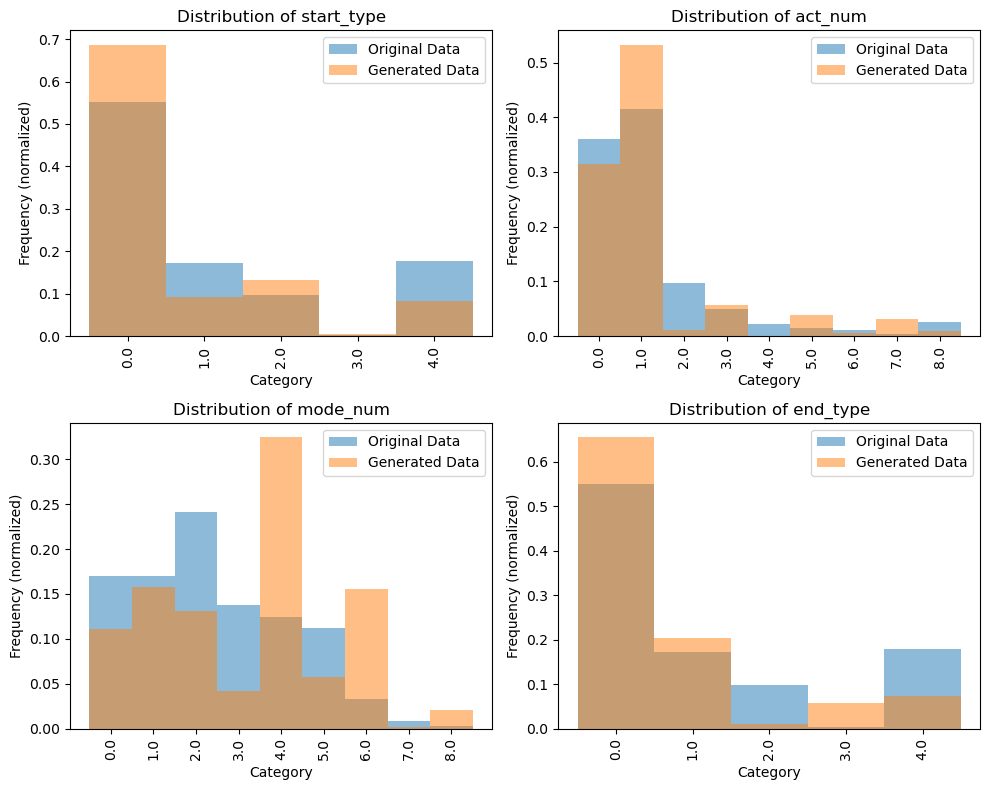

In [14]:
#%% 6. Plotting the Results
# Create a 2x2 grid of subplots for the four features
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Feature names for the title and accessing columns
features = ['start_type', 'act_num', 'mode_num', 'end_type']

# Plot each feature one by one
for i, ax in enumerate(axs.flat):
    # Original data histogram
    ax.hist(data_select.values[:, i], bins=np.arange(len(encoder.categories_[i]) + 1) - 0.5,
            density=True, alpha=0.5, label='Original Data')

    # Generated data histogram
    ax.hist(generated_data[:, i], bins=np.arange(len(encoder.categories_[i]) + 1) - 0.5,
            density=True, alpha=0.5, label='Generated Data')

    # Set titles, labels, and x-axis ticks
    ax.set_title(f'Distribution of {features[i]}')
    ax.set_xlabel('Category')
    ax.set_ylabel('Frequency (normalized)')
    ax.set_xticks(range(len(encoder.categories_[i])))
    ax.set_xticklabels(encoder.categories_[i], rotation=90)

    # Add a legend to each subplot
    ax.legend()

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()
